In [2]:
import numpy as np
import pandas as pd
import scanpy as sc 
import scirpy as ir 
import muon as mu

In [3]:
sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.2 anndata==0.10.8 umap==0.5.6 numpy==1.26.4 scipy==1.14.0 pandas==2.2.2 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.5 pynndescent==0.5.13


In [4]:
mdata = mu.read("/Users/jerryaaaaaa/tcr_model_2.h5mu")

/opt/miniconda3/lib/python3.12/site-packages/anndata/utils.py:334: ExperimentalFeatureWarning: Support for Awkward Arrays is currently experimental. Behavior may change in the future. Please report any issues you may encounter!
  warnings.warn(msg, category, stacklevel=stacklevel)


Drop cells with NA clonal_dynamic_label

In [5]:
valid_cells = mdata["gex"].obs[~mdata["gex"].obs["clonal_dynamic_label"].isna()].index
mdata_filtered = mdata[valid_cells].copy()

Assign proxy label(criteria: reactivity_score > 0.5 and expansion_fold > 1)

In [6]:
def assign_proxy_label(row, score_thresh=0.5, expansion_thresh=1):
    if row["reactivity_score"] > score_thresh and row["expansion_fold"] > expansion_thresh:
        return "Reactive"
    else:
        return "Nonreactive"
mdata_filtered["gex"].obs["proxy_label"] = mdata_filtered["gex"].obs.apply(assign_proxy_label, axis=1)

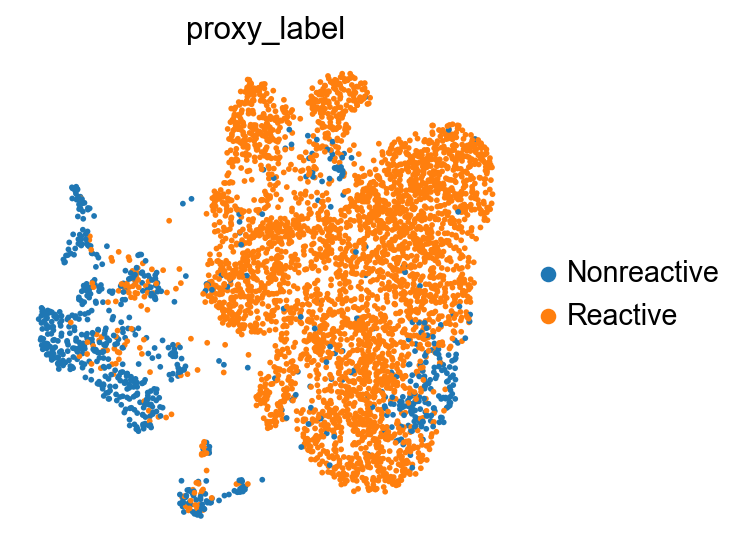

In [7]:
sc.pl.umap(mdata_filtered["gex"], color="proxy_label", frameon=False)

Extract cells_id for train/test split

Stratify = labels(targets) ensures the proportion of each class is preserved in both train and test sets

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
cells_id = mdata_filtered.obs_names
labels = mdata_filtered["gex"].obs["proxy_label"]

train_cells, test_cells = train_test_split(
    cells_id,
    test_size=0.3,
    random_state=42,
    stratify=labels
)
mdata_train = mdata_filtered[train_cells].copy()
mdata_test = mdata_filtered[test_cells].copy()

Differential gene expression(Proxy_label)

In [10]:
sc.tl.rank_genes_groups(mdata_train["gex"], groupby="proxy_label", method="wilcoxon")

ranking genes


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


In [11]:
deg_df = sc.get.rank_genes_groups_df(mdata_train["gex"], group="Reactive")
deg_df_filtered = deg_df[
    (deg_df["pvals_adj"] < 0.05) &
    (deg_df)["logfoldchanges"].abs() > 0.25
]
feature_genes = deg_df_filtered["names"].unique().tolist()

In [12]:
print(f"DEGs: {len(feature_genes)}")

DEGs: 4303


In [13]:
deg_df_filtered.to_csv("/Users/jerryaaaaaa/deg_proxy_3.csv")

In [14]:
X_train = mdata_train["gex"].to_df()[feature_genes]
X_test = mdata_test["gex"].to_df()[feature_genes]

y_train = mdata_train["gex"].obs["proxy_label"].map({"Reactive": 1, "Nonreactive": 0}).astype(int)
y_test = mdata_test["gex"].obs["proxy_label"].map({"Reactive": 1, "Nonreactive": 0}).astype(int)

Classification Model(XGBoost)

In [15]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

Class imbalance

In [17]:
#Compute class ratio
ratio = (y_train == 0).sum() / (y_train == 1).sum()

In [18]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=ratio,
    eval_metric="logloss",
    random_state=42
)

In [19]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [20]:
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

In [21]:
print("ROC_AUC:", roc_auc_score(y_test, y_proba))

ROC_AUC: 0.981698600973236


Cross Validation

In [22]:
from sklearn.model_selection import cross_val_score

In [23]:
scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring="roc_auc")
print("Cross Validated AUCs:", scores)
print("Mean AUC:", np.mean(scores))

Cross Validated AUCs: [0.99298968 0.98913574 0.98608178 0.99091417 0.98500839]
Mean AUC: 0.9888259528483679


Model performance evaluation(ROC_AUC, PR, F1)

In [24]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

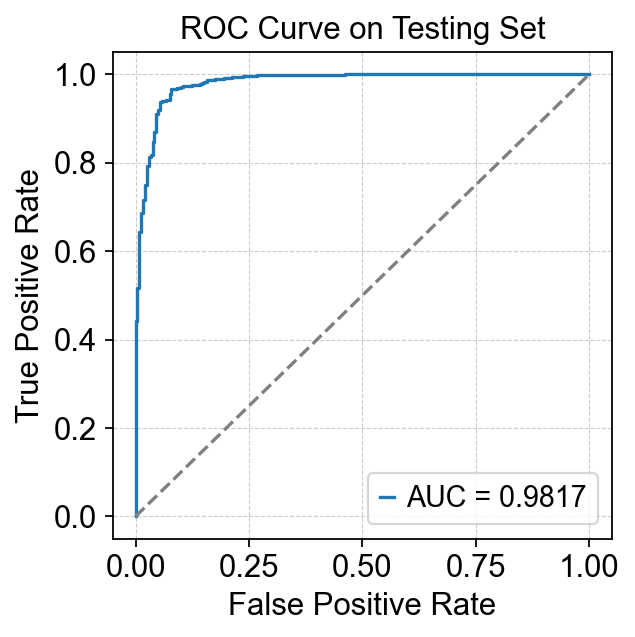

In [25]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve on Testing Set")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()

In [26]:
from sklearn.metrics import precision_recall_curve, average_precision_score

In [27]:
print(classification_report(y_test, y_pred, target_names=["Reactive", "Nonreative"]))

              precision    recall  f1-score   support

    Reactive       0.88      0.88      0.88       240
  Nonreative       0.97      0.97      0.97      1096

    accuracy                           0.96      1336
   macro avg       0.93      0.92      0.93      1336
weighted avg       0.96      0.96      0.96      1336



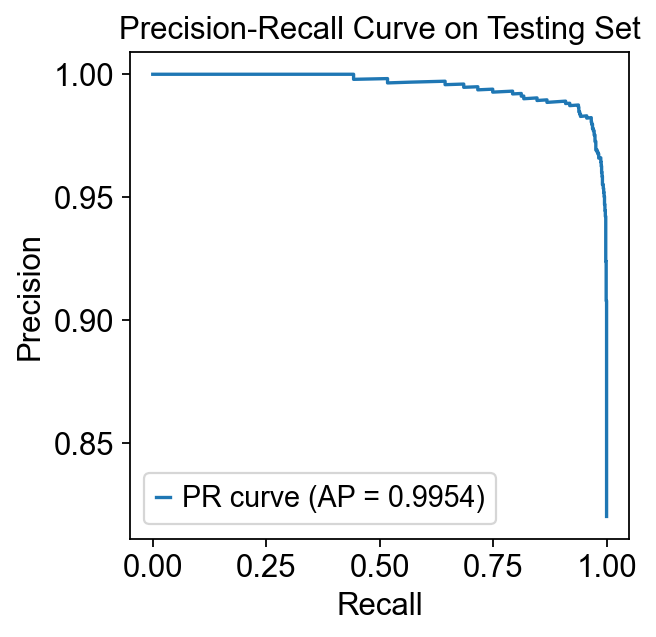

In [28]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)

plt.plot(recall, precision, label=f"PR curve (AP = {ap:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve on Testing Set")
plt.legend()
plt.grid(False)
plt.show()

In [29]:
from sklearn.metrics import f1_score

In [30]:
f1 = f1_score(y_test, y_pred)
print("F1 score:", f1)

F1 score: 0.9735642661804923


Feature importance

In [31]:
import seaborn as sns

In [32]:
importance_dict = xgb_model.get_booster().get_score(importance_type="weight")

importance_df_gex = pd.DataFrame({
    "feature": list(importance_dict.keys()),
    "importance": list(importance_dict.values())
})
importance_df_gex = importance_df_gex.sort_values(by="importance", ascending=False)

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_14955/3953817300.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df_gex.head(20), y="feature", x="importance", palette="magma")


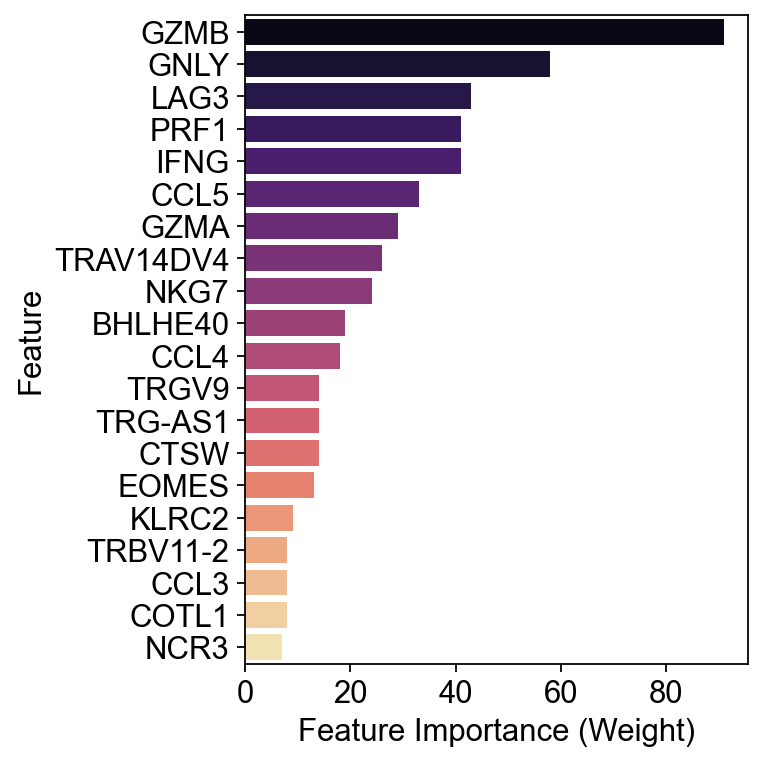

In [33]:
plt.figure(figsize=(5, 5))
sns.barplot(data=importance_df_gex.head(20), y="feature", x="importance", palette="magma")

plt.xlabel("Feature Importance (Weight)")
plt.ylabel("Feature")
plt.grid(False)
plt.tight_layout()
plt.show()

In [48]:
xgb_test_df = pd.DataFrame({
    "clone_id": mdata_test["gex"].obs["clone_id"],
    "reactivity_proba": y_proba
})
test_clone_reactivity = xgb_test_df.groupby("clone_id")["reactivity_proba"].mean()

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_14955/2243210320.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  test_clone_reactivity = xgb_test_df.groupby("clone_id")["reactivity_proba"].mean()


In [49]:
test_clone_reactivity = test_clone_reactivity.reset_index()
test_clone_reactivity.columns = ["clone_id", "avg_reactivity_probability"]

In [50]:
import jenkspy

In [51]:
test_pred_probs = np.array(y_proba)
breaks = jenkspy.jenks_breaks(test_pred_probs, 2)
threshold = breaks[1]
print(f"Fisher-Jenks threshold: {threshold:.4f}")

Fisher-Jenks threshold: 0.5285


In [52]:
test_clone_reactivity["clone_reactivity"] = test_clone_reactivity["avg_reactivity_probability"].apply(
    lambda x: "Reactive" if x > threshold else "Nonreactive"
)

In [53]:
test_clone_reactivity = test_clone_reactivity.set_index("clone_id")
mdata_test["gex"].obs["prediction"] = mdata_test["gex"].obs["clone_id"].map(
    test_clone_reactivity["clone_reactivity"]
)

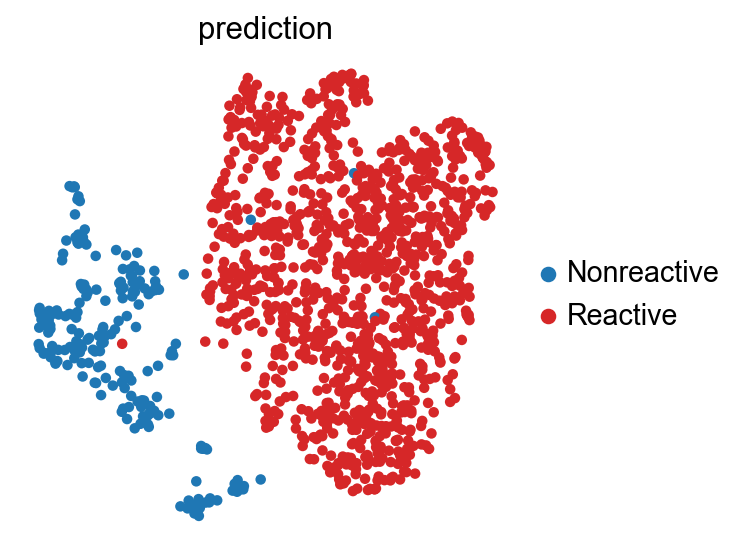

In [54]:
sc.pl.umap(mdata_test["gex"], color="prediction", palette=["tab:blue", "tab:red"], frameon=False)

In [55]:
reactive_clones = test_clone_reactivity[test_clone_reactivity["clone_reactivity"] == "Reactive"]
n_reactive = len(reactive_clones)
print(n_reactive)

22


In [56]:
test_clone_reactivity.reset_index(inplace=True)
test_clone_reactivity

,clone_id,avg_reactivity_probability,clone_reactivity
0,0,0.941221,Reactive
1,1,0.972562,Reactive
2,2,0.965949,Reactive
3,3,0.078454,Nonreactive
4,4,0.155312,Nonreactive
5,5,0.237315,Nonreactive
6,6,0.112497,Nonreactive
7,8,0.060926,Nonreactive
8,9,0.119881,Nonreactive
9,12,0.134247,Nonreactive


Prediction on total mdata(drop NA clonal_dynamic)

In [34]:
X_total = mdata_filtered["gex"].to_df()[feature_genes]

In [35]:
y_total_proba = xgb_model.predict_proba(X_total)[:, 1]

In [36]:
xgb_predict_df = pd.DataFrame({
    "clone_id": mdata_filtered["gex"].obs["clone_id"],
    "reactivity_proba": y_total_proba
})
clone_reactivity = xgb_predict_df.groupby("clone_id")["reactivity_proba"].mean()

/var/folders/s3/tmfhtnzx1g34x3_f84h69dh40000gn/T/ipykernel_14955/3290524566.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  clone_reactivity = xgb_predict_df.groupby("clone_id")["reactivity_proba"].mean()


In [37]:
clone_reactivity = clone_reactivity.reset_index()
clone_reactivity.columns = ["clone_id", "avg_reactivity_probability"]

In [38]:
import jenkspy

In [39]:
pred_probs = np.array(y_total_proba)
breaks = jenkspy.jenks_breaks(pred_probs, 2)
threshold = breaks[1]
print(f"Fisher-Jenks threshold: {threshold:.4f}")

Fisher-Jenks threshold: 0.4945


In [40]:
clone_reactivity["clone_reactivity"] = clone_reactivity["avg_reactivity_probability"].apply(
    lambda x: "Reactive" if x > threshold else "Nonreactive"
)

In [41]:
clone_reactivity = clone_reactivity.set_index("clone_id")
mdata_filtered["gex"].obs["prediction"] = mdata_filtered["gex"].obs["clone_id"].map(
    clone_reactivity["clone_reactivity"]
)

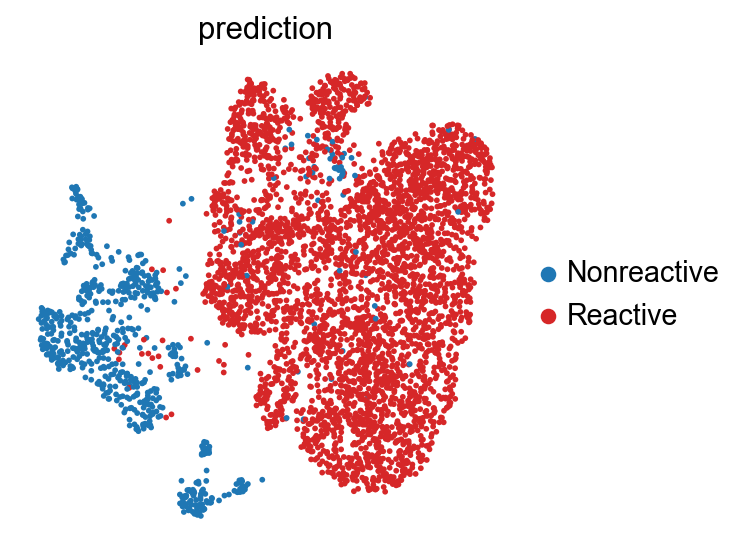

In [42]:
sc.pl.umap(mdata_filtered["gex"], color="prediction", palette=["tab:blue", "tab:red"], frameon=False)

In [43]:
reactive_clones = clone_reactivity[clone_reactivity["clone_reactivity"] == "Reactive"]
n_reactive = len(reactive_clones)
print(n_reactive)

15


In [44]:
clone_reactivity.reset_index(inplace=True)
clone_reactivity

,clone_id,avg_reactivity_probability,clone_reactivity
0,0,0.932102,Reactive
1,1,0.971494,Reactive
2,2,0.968063,Reactive
3,3,0.121042,Nonreactive
4,4,0.264692,Nonreactive
5,5,0.341466,Nonreactive
6,6,0.115212,Nonreactive
7,8,0.054389,Nonreactive
8,9,0.091771,Nonreactive
9,12,0.170649,Nonreactive


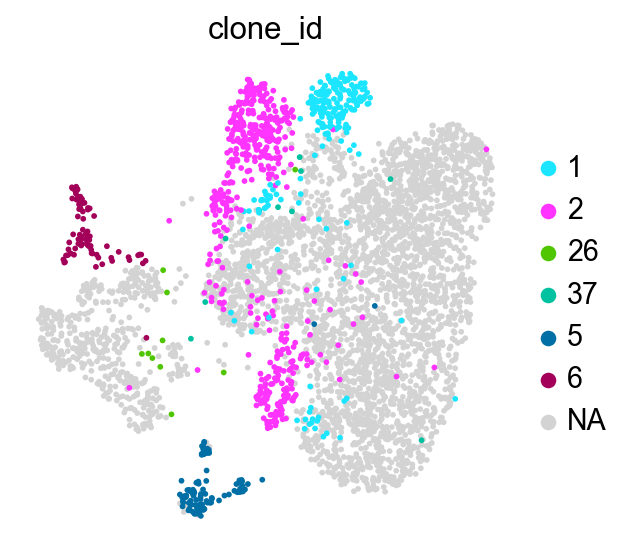

In [67]:
sc.pl.umap(mdata_filtered["gex"], color="clone_id", groups=["26", "37", "5", "6", "1", "2"], frameon=False)